In [1]:
%matplotlib inline
#
# data manipulation and math
#
import numpy as np
import scipy as sp
import pandas as pd
#
# plotting and visualization
#
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
#
import seaborn as sns
#
# modeling
#
from sklearn.preprocessing import OneHotEncoder as OHE
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
#
print("Loaded Libraries")

Loaded Libraries


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
#
plt.rcParams['figure.figsize'] = (3, 3)
plt.style.use('seaborn-pastel')
plt.rcParams['figure.dpi'] = 150      
#
c0 = sns.color_palette()[0]
c1 = sns.color_palette()[1]
c2 = sns.color_palette()[2]
#
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
#

C:\Users\tnels\AppData\Local\Temp\ipykernel_13936\4051103729.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-pastel')


In [3]:
def points_plot(ax, Xtr, Xte, ytr, yte, 
                clf, 
                mesh = True, colorscale = cmap_light, cdiscrete = cmap_bold, 
                alpha = 0.1, psize = 10, 
                zfunc = False, predicted = False):

#
    try:
        feature_names = Xtr.columns
    except:
        feature_names = None
#        
    Xtrain = np.array(Xtr)
    Xtest = np.array(Xte)
#
    h = 0.02
#
# create a uniform grid spanning the range of the X values
# note that y here is NOT the target, it is the 2nd
# dimension of the desired plot
#
    X = np.concatenate((Xtrain, Xtest))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    if zfunc:
        mesh_data = np.c_[xx.ravel(), yy.ravel()]
        if feature_names is not None:
            mesh_data = pd.DataFrame(mesh_data, 
                         columns = feature_names)
        p0 = clf.predict_proba(mesh_data)[:, 0]
        p1 = clf.predict_proba(mesh_data)[:, 1]
        Z = zfunc(p0, p1)

    else:
        mesh_data = np.c_[xx.ravel(), yy.ravel()]
        if feature_names is not None:
            mesh_data = pd.DataFrame(mesh_data, 
                                     columns = feature_names)
        Z = clf.predict(mesh_data)
    ZZ = Z.reshape(xx.shape)

    if mesh:
        plt.pcolormesh(xx, yy, ZZ, 
                       cmap = cmap_light, 
                       alpha = alpha, 
                       axes = ax, 
                       shading = 'auto')

    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte

    ax.scatter(Xtrain[:, 0], Xtrain[:, 1], 
               c = showtr - 1, 
               cmap = cmap_bold, 
               s = psize, 
               alpha = alpha, 
               edgecolor = "k")

    ax.scatter(Xtest[:, 0], Xtest[:, 1],
               c = showte - 1, 
               cmap = cmap_bold, 
               s = psize + 10,
               alpha = alpha, 
               marker = "s")
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
#
    return ax, xx, yy

In [4]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, 
                     clf, colorscale = cmap_light, cdiscrete = cmap_bold, 
                     ccolor = cm, 
                     alpha = 0.1, psize = 10):
    try:
        feature_names = Xtr.columns
    except:
        feature_names = None
#        
    Xtrain = np.array(Xtr)
    Xtest = np.array(Xte)
#    
    ax, xx, yy = points_plot(ax, Xtr, Xte, ytr, yte,
                         clf,
                         mesh = False, 
                         colorscale = colorscale, cdiscrete = cdiscrete, 
                         psize = psize, alpha = alpha,
                         predicted = True) 
    mesh_data = np.c_[xx.ravel(), yy.ravel()]
    if feature_names is not None:
        mesh_data = pd.DataFrame(mesh_data, 
                     columns = feature_names)    
    Z = clf.predict_proba(mesh_data)[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap = ccolor, alpha = 0.2)
    cs2 = plt.contour(xx, yy, Z, cmap = ccolor, alpha = 0.6)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize = 12)
#
    plt.show()

In [6]:
dflog = pd.read_excel("heart.xlsx")
#
print('The data have ', dflog.shape[0], ' rows and ', dflog.shape[1], ' columns\n')
print('column names: \n')
print('\n'.join(list(dflog.columns)))

The data have  270  rows and  14  columns

column names: 

age_yr
sex_M_F
chest_pain_value
resting_BP_mm_Hg
cholesterol_mg_dl
fasting_blood_sugar_high
ECG_value
max_HR
exercise_angina
ST_depresssion_exercise
ST_slope_peak
number_vessels_involved
defect_diag
heart_disease


In [7]:
dflog.head()

,age_yr,sex_M_F,chest_pain_value,resting_BP_mm_Hg,cholesterol_mg_dl,fasting_blood_sugar_high,ECG_value,max_HR,exercise_angina,ST_depresssion_exercise,ST_slope_peak,number_vessels_involved,defect_diag,heart_disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,1
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,0
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,1
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,0
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,0


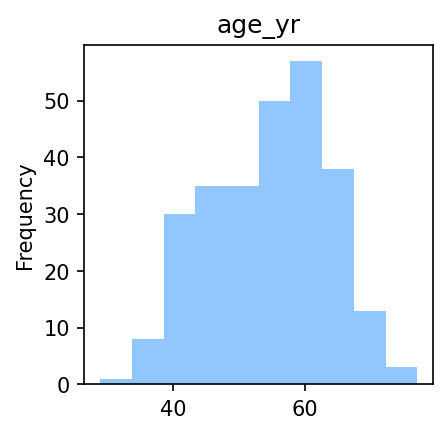

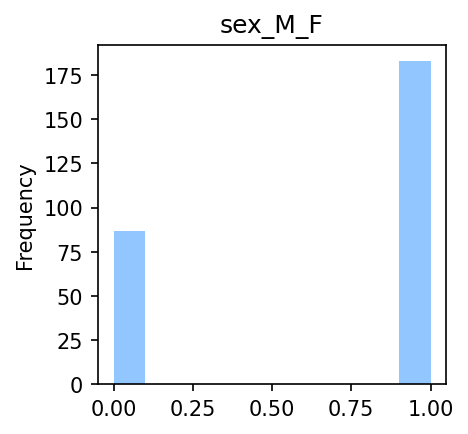

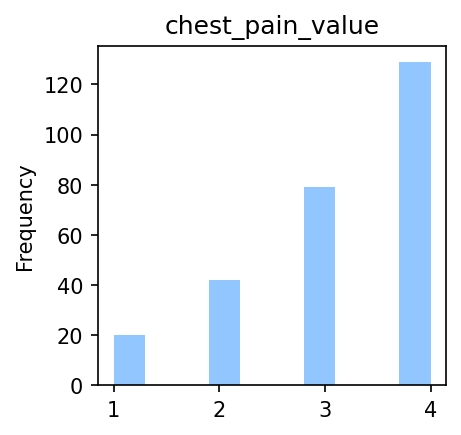

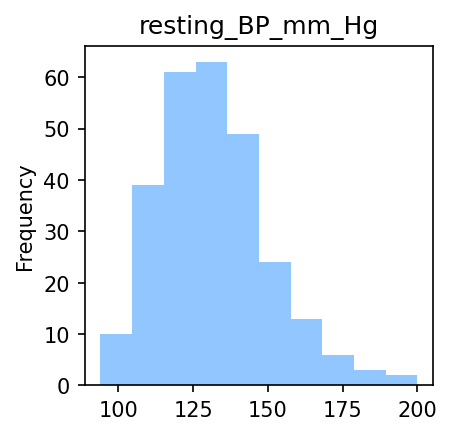

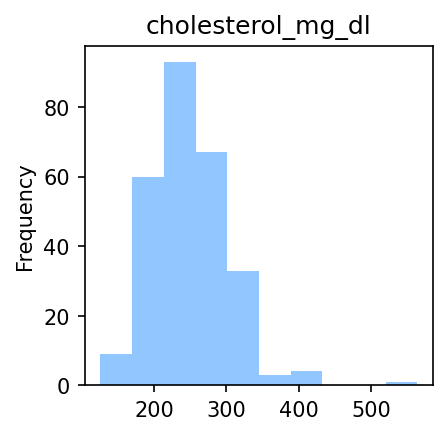

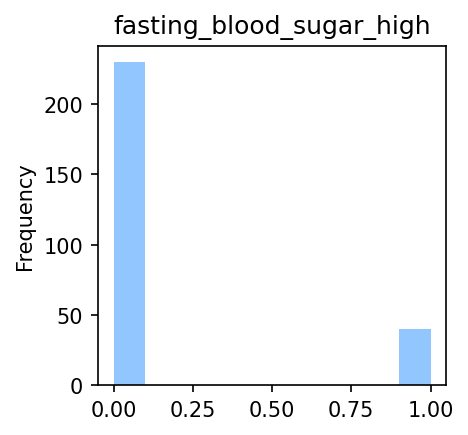

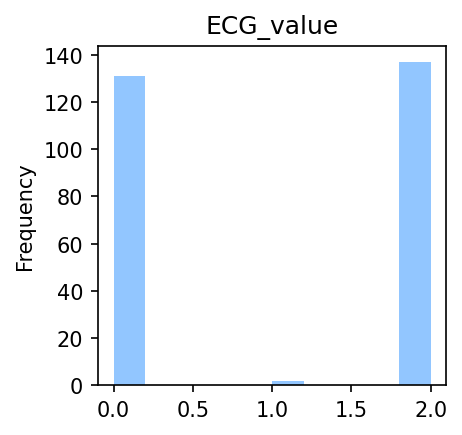

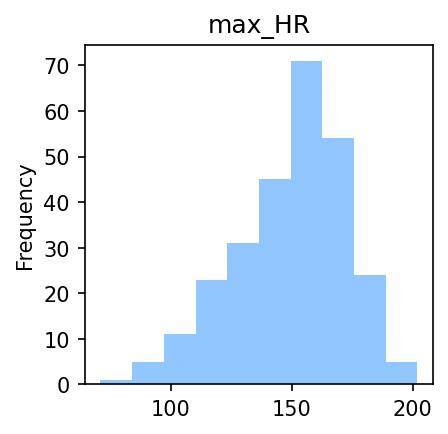

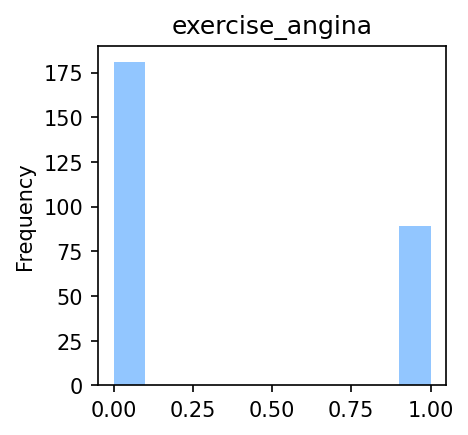

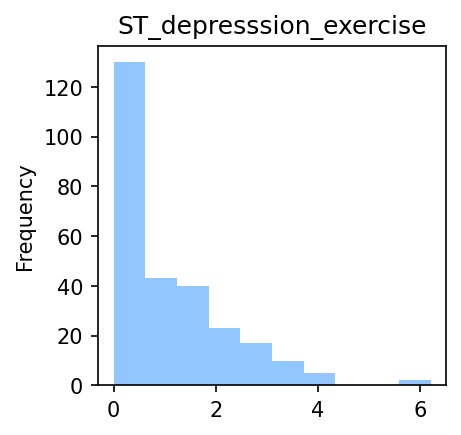

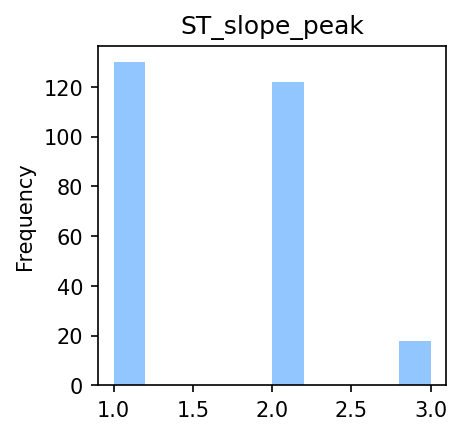

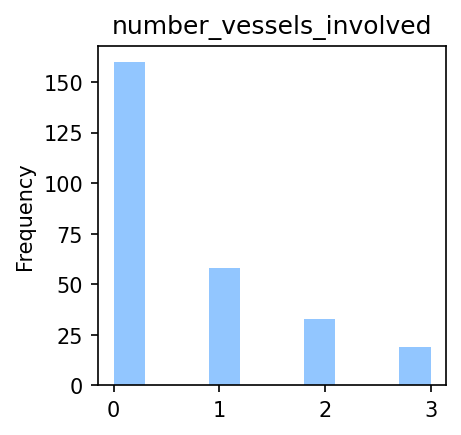

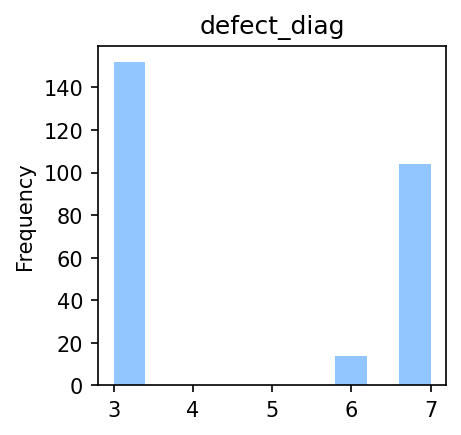

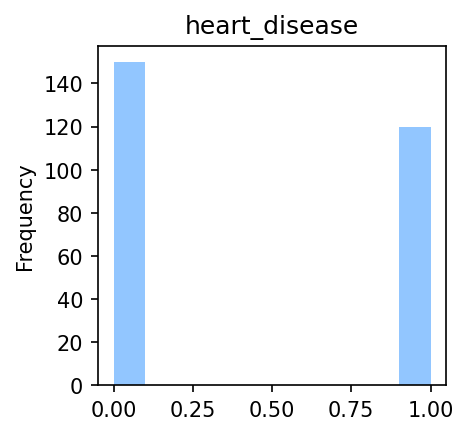

In [7]:
for col in list(dflog.columns):
    dflog[col].plot(kind = 'hist', title = col)
    plt.show()

In [8]:
#
# extract the age as a Series, and inspect the values
#
x = dflog['age_yr']
print('first 6 lines of age data:\n', x.head(6))
print('\nsummary statistics of age:\n', x.describe())

first 6 lines of age data:
 0    70
1    67
2    57
3    64
4    74
5    65
Name: age_yr, dtype: int64

summary statistics of age:
 count    270.000000
mean      54.433333
std        9.109067
min       29.000000
25%       48.000000
50%       55.000000
75%       61.000000
max       77.000000
Name: age_yr, dtype: float64


In [10]:
#
# do the same for the resting blood pressure
#
y = dflog['resting_BP_mm_Hg']
print('first six lines of blood pressure data:\n', y.head(6))
print('\nsummary statistics of blood pressure:\n', y.describe())

first six lines of blood pressure data:
 0    130
1    115
2    124
3    128
4    120
5    120
Name: resting_BP_mm_Hg, dtype: int64

summary statistics of blood pressure:
 count    270.000000
mean     131.344444
std       17.861608
min       94.000000
25%      120.000000
50%      130.000000
75%      140.000000
max      200.000000
Name: resting_BP_mm_Hg, dtype: float64


In [11]:
categorical_features = ['sex_M_F',
                        'chest_pain_value',
                        'ECG_value',
                        'ST_slope_peak',
                        'defect_diag']
dflog = pd.get_dummies(dflog, columns = categorical_features)
print('The data have ', dflog.shape[0], ' rows and ', dflog.shape[1], ' columns\n')
print('column names: \n')
print('\n'.join(list(dflog.columns)))

The data have  270  rows and  24  columns

column names: 

age_yr
resting_BP_mm_Hg
cholesterol_mg_dl
fasting_blood_sugar_high
max_HR
exercise_angina
ST_depresssion_exercise
number_vessels_involved
heart_disease
sex_M_F_0
sex_M_F_1
chest_pain_value_1
chest_pain_value_2
chest_pain_value_3
chest_pain_value_4
ECG_value_0
ECG_value_1
ECG_value_2
ST_slope_peak_1
ST_slope_peak_2
ST_slope_peak_3
defect_diag_3
defect_diag_6
defect_diag_7


In [12]:
class_counts = dflog['heart_disease'].value_counts()
class_counts

heart_disease
0    150
1    120
Name: count, dtype: int64

Notice that class_counts is a Pandas Series object:

In [13]:
type(class_counts)

pandas.core.series.Series

In [14]:
class_percentages = pd.Series([(x / dflog.shape[0]) * 100.00 for x in class_counts])
class_percentages

0    55.555556
1    44.444444
dtype: float64

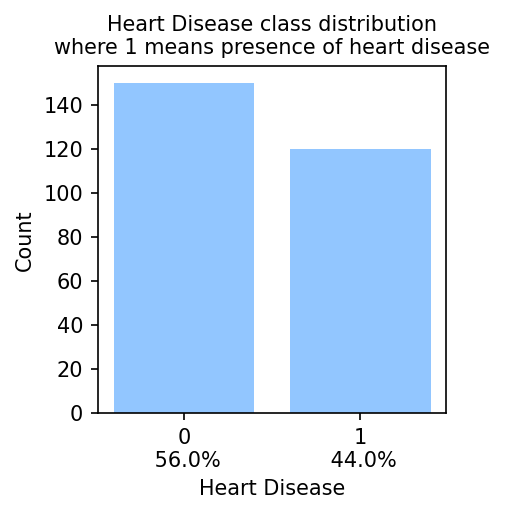

In [15]:
fig, ax = plt.subplots()
ax.bar(class_counts.index, class_counts)
ax.set_xticks([0, 1])
ax.set_xticklabels(class_percentages.index.astype(str) + '\n' + ' ' +
                   class_percentages.round(0).astype(str) + '%')
ax.set_ylabel('Count')
ax.set_xlabel('Heart Disease')
ax.set_title('Heart Disease class distribution\nwhere 1 means presence of heart disease',
              fontsize = 10)
plt.show()

In [16]:
Xtrain, Xtest, ytrain, ytest = train_test_split(dflog[['cholesterol_mg_dl','resting_BP_mm_Hg']],
                                                dflog['heart_disease'],
                                                train_size = 0.80,
                                                random_state = 42)

In [17]:
classifier = LogisticRegression(solver = 'liblinear', max_iter = 500, C = 1000)

In [19]:
print(f'Accuracy on training data: {accuracy_score(classifier.predict(Xtrain), ytrain):.2f}')

Accuracy on training data: 0.61


In [20]:
print(f'Accuracy on test data: {accuracy_score(classifier.predict(Xtest), ytest):.2f}')

Accuracy on test data: 0.59


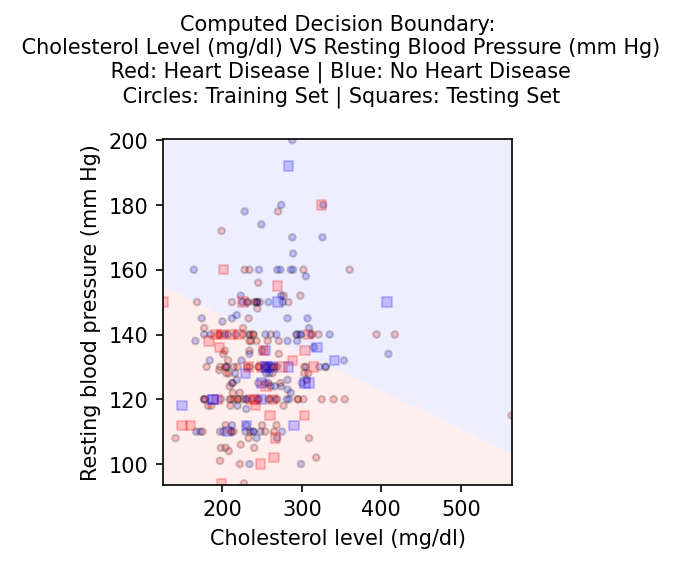

In [21]:
plt.figure()
ax = plt.gca()
ax.set_ylabel('Resting blood pressure (mm Hg)')
ax.set_xlabel('Cholesterol level (mg/dl)')
ax.set_title('Computed Decision Boundary:\n ' +
             'Cholesterol Level (mg/dl) VS Resting Blood Pressure (mm Hg)' +
             '\n Red: Heart Disease | Blue: No Heart Disease' +
             '\n Circles: Training Set | Squares: Testing Set\n',
            fontsize = 10)
_ = points_plot(ax, Xtrain, Xtest, ytrain, ytest, classifier, alpha = 0.2)

In [22]:
print("Classification Report for Training Data")
print(classification_report(ytrain, classifier.predict(Xtrain)))

Classification Report for Training Data
              precision    recall  f1-score   support

           0       0.61      0.78      0.68       117
           1       0.61      0.40      0.48        99

    accuracy                           0.61       216
   macro avg       0.61      0.59      0.58       216
weighted avg       0.61      0.61      0.59       216



In [23]:
print("Classification Report for Test Data")
print(classification_report(ytest, classifier.predict(Xtest)))

Classification Report for Test Data
              precision    recall  f1-score   support

           0       0.63      0.82      0.71        33
           1       0.45      0.24      0.31        21

    accuracy                           0.59        54
   macro avg       0.54      0.53      0.51        54
weighted avg       0.56      0.59      0.56        54



In [24]:
X = dflog.drop(columns = ['heart_disease'])
print("X: ", type(X), X.shape)

X:  <class 'pandas.core.frame.DataFrame'> (270, 23)


Notice that ``X`` is a ``pandas`` DataFrame with 270 rows and 23 columns (a.k.a. a matrix).

In [25]:
y = dflog['heart_disease']
print("y: ", type(y), y.shape)

y:  <class 'pandas.core.series.Series'> (270,)


In [27]:
list(X.columns)

['age_yr',
 'resting_BP_mm_Hg',
 'cholesterol_mg_dl',
 'fasting_blood_sugar_high',
 'max_HR',
 'exercise_angina',
 'ST_depresssion_exercise',
 'number_vessels_involved',
 'sex_M_F_0',
 'sex_M_F_1',
 'chest_pain_value_1',
 'chest_pain_value_2',
 'chest_pain_value_3',
 'chest_pain_value_4',
 'ECG_value_0',
 'ECG_value_1',
 'ECG_value_2',
 'ST_slope_peak_1',
 'ST_slope_peak_2',
 'ST_slope_peak_3',
 'defect_diag_3',
 'defect_diag_6',
 'defect_diag_7']

#### (b) Perform train/test split on $(X, y)$

In [29]:
Xlr, Xtestlr, ylr, ytestlr = train_test_split(X, y, random_state = 2)
print('Training split has ', Xlr.shape[0], ' rows\n',
      'and the corresponding labels have an equal number of values.', 
      '(' + str(len(ylr))+ ')')
print('Test split has ', Xtestlr.shape[0], ' rows\n',
      'and the corresponding labels have an equal number of values.', 
      '(' + str(len(ytestlr)) + ')')

Training split has  202  rows
 and the corresponding labels have an equal number of values. (202)
Test split has  68  rows
 and the corresponding labels have an equal number of values. (68)


In [30]:
def plot_y_ratios(y, ytest):
    fig, ax = plt.subplots(2, sharex = True)
    ax[0].bar(x = [0, 1], height = [y[y == 0].count(), 
                                    y[y == 1].count()])
    ax[0].set_ylabel('train', fontsize = 8)
    ax[0].set_ylim(0, 125)
    ax[1].bar(x = [0, 1], height = [ytest[ytest == 0].count(),
                                    ytest[ytest == 1].count()])
    ax[1].set_ylabel('test', fontsize = 8)
    ax[1].set_ylim(0, 125)
    ax[1].set_xticks([0, 1])
    ax[0].tick_params(which = 'both', labelsize = 8)
    ax[1].tick_params(which = 'both', labelsize = 8)
    ax[1].set_xlabel('heart disease\n(0 = no disease)', fontsize = 8)
    ax[0].set_title('% heart disease (where 1 means presence of heart diseases):\n' +
                    'train: ' + str(round(100 * (y[y ==1].count()/y.shape[0]), 0)) +
                    '\ntest: ' + str(round(100 * (ytest[ytest ==1].count()/ytest.shape[0]), 0)),
                   fontsize = 10)
    plt.show() 

Now we can inpsect the train response data (ylr) compared to the test response data (ytestlr).

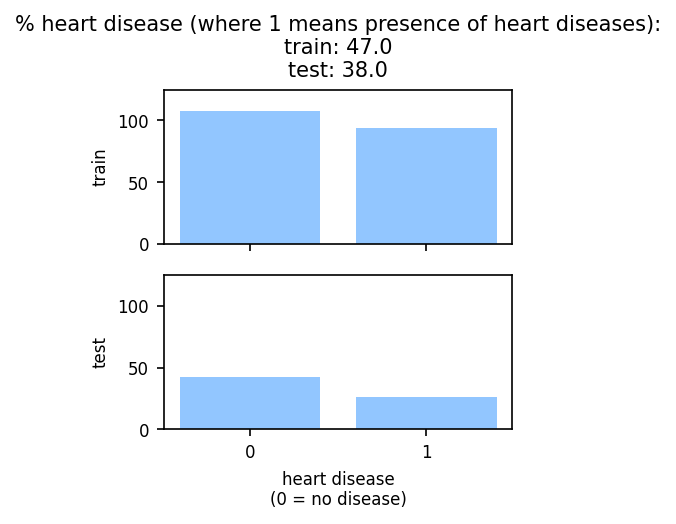

In [28]:
plot_y_ratios(ylr, ytestlr)

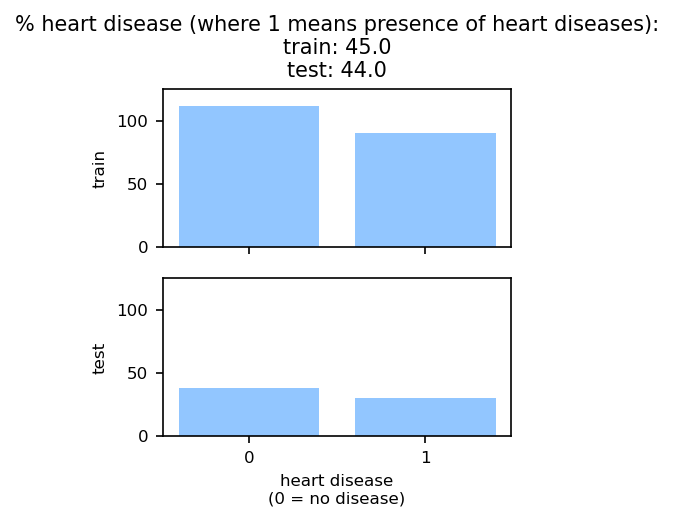

In [31]:
Xlrstrat, Xtestlrstrat, ylrstrat, ytestlrstrat = train_test_split(X, y, 
                                                                  random_state = 2, 
                                                                  stratify = y)
plot_y_ratios(ylrstrat, ytestlrstrat)

In [32]:
clf = LogisticRegression(solver = 'newton-cg', max_iter = 500)

In [33]:
clf.fit(Xlrstrat, ylrstrat) 

LogisticRegression(max_iter=500, solver='newton-cg')

In [34]:
y_predict_test = clf.predict(Xtestlrstrat)
y_predict_training = clf.predict(Xlrstrat)

In [35]:
print("[Test] Accuracy score (y_predict_test, ytestlrstrat):",
      f'{accuracy_score(y_predict_test, ytestlrstrat):.2f}')

[Test] Accuracy score (y_predict_test, ytestlrstrat): 0.81


In [36]:
print("[Test] Accuracy score: (ytestlrstrat, y_predict_test) [**note reversed order]", 
      f'{accuracy_score(ytestlrstrat, y_predict_test):.2f}')

[Test] Accuracy score: (ytestlrstrat, y_predict_test) [**note reversed order] 0.81


And compute the metric on the training data:

In [37]:
print("[Training] Accuracy score: (ylrstrat, y_predict_training)", 
      f'{accuracy_score(ylrstrat, y_predict_training):.2f}')

[Training] Accuracy score: (ylrstrat, y_predict_training) 0.89


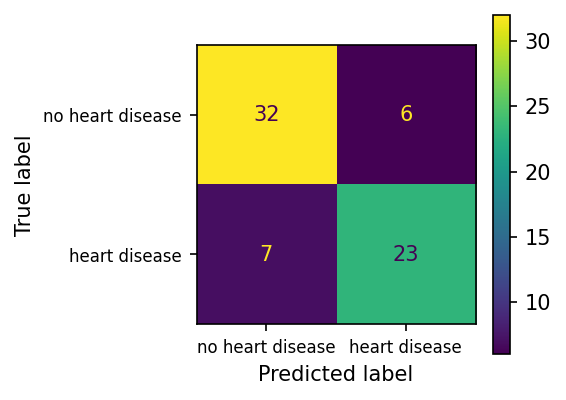

In [36]:
cm = confusion_matrix(ytestlrstrat, y_predict_test, labels = clf.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['no heart disease', 'heart disease'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['no heart disease', 'heart disease'], fontsize = 8)
ax.set_yticklabels(labels = ['no heart disease', 'heart disease'], fontsize = 8)
display_cm.plot(ax = ax)

Note the ability to add human readable labels (as compared to just 0 or 1). From the chart we can see that while the overall accuracy was 81%, when we predict heart disease, 20% (6 of 29) of the time we are predicting a false positive, while the false negatives (predicting no disease when in fact there is heart disease) is about 18% (7 of 39). This information can be discussed with stakeholders to decide which is more important, reducing false positives or false negatives, assuming overall accuracy is acceptable. We can also use the ``classification_report`` method from earlier on this case--and notice that all the metrics in the report (precision, recall, and f1-score) can be computed from the values in the confusion matrix:

In [38]:
print(classification_report(ylrstrat, y_predict_training))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       112
           1       0.90      0.84      0.87        90

    accuracy                           0.89       202
   macro avg       0.89      0.89      0.89       202
weighted avg       0.89      0.89      0.89       202



In [39]:
print(classification_report(ytestlrstrat, y_predict_test))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83        38
           1       0.79      0.77      0.78        30

    accuracy                           0.81        68
   macro avg       0.81      0.80      0.81        68
weighted avg       0.81      0.81      0.81        68



In [40]:
#
# here we try multiple splits and see the effects, with the same proportion 75% train and 25% test
#
# keep lists for training accuracy, 
#                test accuracy, 
#                and the difference between the latter and the former
#
training_accuracy = []
test_accuracy = []
accuracy_difference = []
#
# define number of trials
#
n_splits = 25
#
# define LogisticRegression object
#
clf = LogisticRegression(solver = 'newton-cg', max_iter = 500)
#
# loop over multiple trials
#
for i in range(0, n_splits):
#
# perform a split for this iteration, 
# using different random_state for every iteration
# this ensures each split is likely to be unique
#
    Xlr, Xtestlr, ylr, ytestlr = train_test_split(X, y, stratify = y, random_state = i)
#    
# fit the Classifier on the training set
#
    clf.fit(Xlr, ylr)
#
# predict the labels for the training data
#
    y_predict_training = clf.predict(Xlr)
#
# predict the labels for the test data
#
    y_predict_test = clf.predict(Xtestlr)
#
# save training set accuracy for this split
#
    tr_accuracy = accuracy_score(y_predict_training, ylr)
    training_accuracy.append(tr_accuracy)
#
# save test set accuracy for this split
#
    tst_accuracy = accuracy_score(y_predict_test, ytestlr)
    test_accuracy.append(tst_accuracy)
#
# save difference between the two acuracy values
#
    accuracy_difference.append(tst_accuracy - tr_accuracy)

The above code generates 25 unique experiments varying the train-test split indices within the original data.  Now we plot all the trials for both the training and test data, to compare the results.

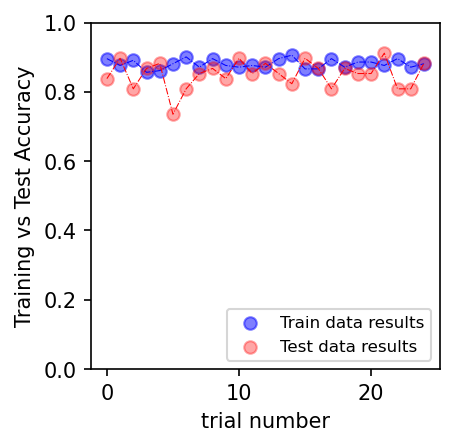

In [41]:
fig, ax = plt.subplots()
ax.scatter(range(len(training_accuracy)),
           training_accuracy, 
           color = 'blue', 
           alpha = 0.5,
           label = 'Train data results')
ax.plot(range(len(training_accuracy)),
        training_accuracy, 
        color = 'blue', 
        linestyle = '-.',
        linewidth = 0.5)
ax.scatter(range(len(test_accuracy)),
           test_accuracy, 
           color = 'red', 
           alpha = 0.35, 
           label = 'Test data results')
ax.plot(range(len(test_accuracy)),
        test_accuracy, 
        color = 'red', 
        linestyle = '-.',
        linewidth = 0.5)
ax.legend(fontsize = 8, loc = "lower right")
ax.set_ylabel('Training vs Test Accuracy')
ax.set_ylim(0, 1)
ax.set_xlabel('trial number')
plt.show()

Note that the accuracy on the train split is relatively constant. This is generally expected since the model is given the train data to fit. On the other hand, the test results vary somewhat more. Another way to look at these results is to plot the difference between the test accuracy and the train accuracy, which is done here.

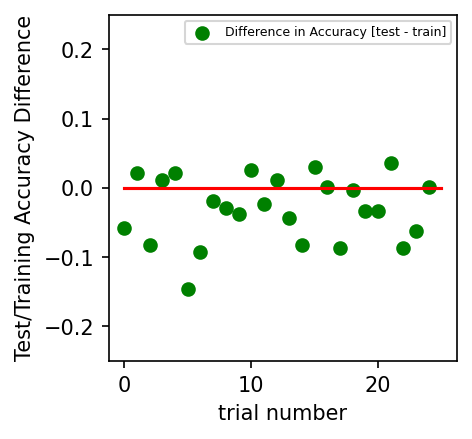

In [42]:
fig, ax = plt.subplots()
ax.scatter(range(len(accuracy_difference)),
           accuracy_difference, 
           color = 'green', 
           label = 'Difference in Accuracy [test - train]')
ax.plot([0, len(accuracy_difference)], [0, 0], 'red')
ax.legend(fontsize = 6)
ax.set_ylabel('Test/Training Accuracy Difference')
ax.set_ylim(-0.25, 0.25)
ax.set_xlabel('trial number')
plt.show()

In this case, the test accuracy is sometimes better, but not by very much--a maximum difference of no more than 0.15 units.  We've already noted that accuracy isn't always a good measure of model performance, and shown the use of the confusion matrix. Additional performance measures are provided by sklearn in the ``classifcation_report`` method (ref: [sklearn.metrics.classification_report](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), including ``precision``, ``recall``, and ``f1-score``.  Note that if desired, we could graph multiple classification performance metrics similarly to the accuracy difference plot above. We won't do a deep dive on metrics here, but below we use the ``classification_report`` method to demonstrate the additional metrics. Note that since we didn't store the intermediate models, the following outputs results from the last of the 25 trials performed.

In [43]:
print("[Training Classification Report]")
print(classification_report(ylr, y_predict_training))
#
print("[Test Classification Report]")
print(classification_report(ytestlr, y_predict_test))

[Training Classification Report]
              precision    recall  f1-score   support

           0       0.88      0.91      0.89       112
           1       0.88      0.84      0.86        90

    accuracy                           0.88       202
   macro avg       0.88      0.88      0.88       202
weighted avg       0.88      0.88      0.88       202

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.86      0.95      0.90        38
           1       0.92      0.80      0.86        30

    accuracy                           0.88        68
   macro avg       0.89      0.87      0.88        68
weighted avg       0.89      0.88      0.88        68



With the more detailed classification report, we see that the metrics are similar for the training and test sets. If you look back at the two plots, you will notice the last points for train and test are more or less on top of each other. The [ISLR book](http://www-bcf.usc.edu/~gareth/ISL/) has explanations of the meaning of these performance metrics, and the Wikipedia entries for them are also quite good (see [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall)).

## Logistic Regression Parameters in scikit-learn

It's a good habit to get into to use help(object) in Python to see details of the object.  If the object is a class from a large package like scikit-learn, you generally will get a version of the documentation similar to what you might find searching the web. By using help(), you are sure to get the information for the exact version you are using.  Here, use help(LogisticRegression) to get information about this class from scikit-learn.

In [47]:
help(LogisticRegression)

Help on class LogisticRegression in module sklearn.linear_model._logistic:

class LogisticRegression(sklearn.linear_model._base.LinearClassifierMixin, sklearn.linear_model._base.SparseCoefMixin, sklearn.base.BaseEstimator)
 |  LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
 |  
 |  Logistic Regression (aka logit, MaxEnt) classifier.
 |  
 |  In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
 |  scheme if the 'multi_class' option is set to 'ovr', and uses the
 |  cross-entropy loss if the 'multi_class' option is set to 'multinomial'.
 |  (Currently the 'multinomial' option is supported only by the 'lbfgs',
 |  'sag', 'saga' and 'newton-cg' solvers.)
 |  
 |  This class implements regularized logistic regression using the
 |  'liblinear' library, 'newton-cg', 's

In [44]:
def cv_score(clf, x, y, score_func = accuracy_score):
    result = 0
    nfold = 5
    x.reset_index(drop = True, inplace = True)
    y.index = x.index
    for train, test in KFold(nfold, shuffle = True,
                             random_state = 42).split(x):
        clf.fit(x.loc[train, :], y[train])
        result += score_func(clf.predict(x.loc[test, :]), y[test])
    return result / nfold

Below is an example of using the `cv_score` function for a basic logistic regression model without regularization.

In [45]:
clf = LogisticRegression(solver = 'liblinear', max_iter = 500)
score = cv_score(clf, Xlr, ylr)
print(f'{score:.2f}')

0.83


It's very important to understand this result. Earlier we showed that with different random splits, the train and test score would vary, and in our case the test score varied more than the train score. The key idea of cross-validation is to peform multiple splits. In this case, we defined our cv_score() function to return the average score across all splits. This is intended to be an estimate of the most likely performance of the model on unseen data. However, the actual results will still vary. Note that in this case the value is in between what we obtained with a single split for the train set and the test set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<b>Exercise:</b> Implement the following search procedure to find a good model
<ul>
<li> You are given a list of possible values of `C` below
<li> For each `C`:
  <ol>
  <li> Create a logistic regression model with that value of `C`
  <li> Find the average score for this model using the `cv_score` function **only on the training set** `(Xlr, ylr)`
  </ol>
<li> Pick the `C` with the highest average score
</ul><br>
Your goal is to find the best model parameters based *only* on the training set, without showing the model test set at all (which is why the test set is also called a *hold-out* set).  

Comment on the value of the score using the best `C` vs. what we had before.
</div>

In [56]:
#
# the grid of parameters to search over
#
Cs = [0.001, 0.1, 1, 10, 100]
#
# your turn
training_accuracy = []
test_accuracy = []
accuracy_difference = []

for i in Cs:
    clf = LogisticRegression(C=i, solver = 'newton-cg', max_iter = 500)
    Xlr, Xtestlr, ylr, ytestlr = train_test_split(X, y, stratify = y, random_state = 23)
#
    clf.fit(Xlr, ylr)
    y_predict_training = clf.predict(Xlr)

    tr_accuracy = accuracy_score(y_predict_training, ylr)
    training_accuracy.append(tr_accuracy)
    
print(training_accuracy)
print('It would seem that either of the last two paramaters (10 or 100) are optimal, and they returned the same score')


[0.7326732673267327, 0.8712871287128713, 0.8712871287128713, 0.8762376237623762, 0.8762376237623762]
It would seem that either of the last two paramaters (10 or 100) are optimal, and they returned the same score


<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3><br>
    <b>Exercise:</b> Now you want to estimate how this model will predict on unseen data in the following way:
<ol>
    <li> Use the <i>C</i> you obtained from the procedure earlier and train a Logistic Regression on the training data
<li> Calculate the accuracy on the test data
</ol>

You may notice that this particular value of <i>C</i> may or may not do as well as simply running the default model on a random train-test split.

<ul>
<li> Do you think that's a problem? 
<li> Why do we need to do this whole cross-validation and grid search stuff anyway?
</ul>

</div>

In [60]:
#
# your turn
#

training_accuracy = []
test_accuracy = []
accuracy_difference = []

clf = LogisticRegression(C=10, solver = 'newton-cg', max_iter = 500)
Xlr, Xtestlr, ylr, ytestlr = train_test_split(X, y, stratify = y, random_state = 23)
clf.fit(Xlr, ylr)
y_predict_training = clf.predict(Xlr)
y_predict_test = clf.predict(Xtestlr)

tr_accuracy = accuracy_score(y_predict_training, ylr)
training_accuracy.append(tr_accuracy)
tst_accuracy = accuracy_score(y_predict_test, ytestlr)
test_accuracy.append(tst_accuracy)
    
print('The accuracy of the model on the training set is', training_accuracy)
print('The accuracy of the model on the test set is', test_accuracy)

The accuracy of the model on the training set is [0.8762376237623762]
The accuracy of the model on the test set is [0.8088235294117647]


### Black Box Grid Search in `sklearn`

Scikit-learn, as with many other Python packages, provides utilities to perform common operations so you do not have to implement them yourself. It is important to understand the mechanics of each operation, but at a certain point, you will want to use the utility instead to save time...

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<b>Exercise:</b> Use scikit-learn's [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html) tool to perform cross validation and grid search. 

* Instead of writing your own loops above to iterate over the model parameters, can you use GridSearchCV to find the best model over the training set? 
* Does it give you the same best value of C?
* How does this model you've obtained perform on the test set?

In [67]:
#
# your turn
#
Cs = {'C': [0.001, 0.1, 1, 10, 100]}

grid = sklearn.model_selection.GridSearchCV(estimator=clf, param_grid=Cs, cv=5)
grid.fit(Xlr, ylr)

Cscore = grid.best_params_
Bscore = grid.best_score_
print('Best C is', Cscore)
print('Best score is', Bscore)


Best C is {'C': 1}
Best score is 0.8410975609756097


So in a few lines of code, utilizing the functionality provied by scikit-learn, you can reproduce what took about 20 lines of code "from scratch". The goal here was to illustrate how to understand what is occurring when you use these advanced features.  It's always a good idea to do some experimenting and exploring to ensure you understand the tools you are using!

### Summary



This case study has introduced using the Logistic Regression algorithm to classify a binary outcome, in this case the presence or absence of heart disease. You have seen how to tune a hyperparamter *C*, the  "inverse regularization strength" to get a model that has a good average cross-vaidation score on the held-out data.  

Logistic regression is an excellent choice for a "baseline" classifier, even when you plan to test more complicated algorithms on a problem. Have a well-performing baseline makes it more clear when using a more complex method adds value.

## Optional: Appendix  
#### Note: 
Most of the following material is taken verbatim from the Logistic Regression section of the CS109 tutorial found at https://github.com/cs109/2015lab5/blob/master/Classification.ipynb

### A Walkthrough of the Math Behind Logistic Regression

We could approach classification as linear regression, where the class, 0 or 1, is the target variable $y$. But this ignores the fact that our output $y$ is discrete valued, and futhermore, the $y$ predicted by linear regression will in general take on values less than 0 and greater than 1. Thus this does not seem like a very good idea.

But what if we could change the form of our hypotheses $h(x)$ instead?

The idea behind logistic regression is very simple. We want to draw a line in feature space that divides the '1' samples from the '0' samples, just like in the diagram above. In other words, we wish to find the "regression" line which divides the samples. Now, a line has the form $w_1 x_1 + w_2 x_2 + w_0 = 0$ in 2-dimensions. On one side of this line we have 

$$w_1 x_1 + w_2 x_2 + w_0 \ge 0,$$

and on the other side we have 

$$w_1 x_1 + w_2 x_2 + w_0 < 0.$$ 

Our classification rule then becomes:

\begin{eqnarray*}
y = 1\;\; &if&\; \textbf{w}\cdot\textbf{x} \ge 0\\
y = 0\;\; &if&\; \textbf{w}\cdot\textbf{x} < 0
\end{eqnarray*}

where $ \textbf{x}$ is the vector $\{1,x_1, x_2,...,x_n\}$ where we have also generalized to more than 2 features.

What hypotheses $h$ can we use to achieve this? One way to do so is to use the **sigmoid** function:

$$h(z) = \frac{1}{1 + e^{-z}}.$$

Notice that at $z=0$ this function has the value 0.5. If $z > 0$, $h > 0.5$ and as $z \to \infty$, $h \to 1$. If $z < 0$, $h < 0.5$ and as $z \to -\infty$, $h \to 0$. As long as we identify any value of $y > 0.5$ as 1, and any $y < 0.5$ as 0, we can achieve what we wished above.

This function is plotted below:

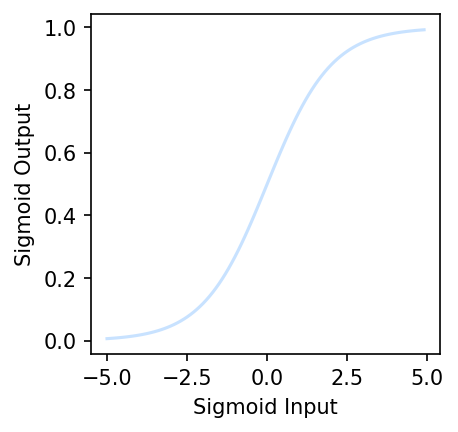

In [46]:
h = lambda z: 1. / (1 + np.exp(-z))
zs = np.arange(-5, 5, 0.1)
fig, ax = plt.subplots()
ax.plot(zs, h(zs), alpha=0.5)
ax.set_ylabel('Sigmoid Output')
ax.set_xlabel('Sigmoid Input')
plt.show()

You can see the effect of the Sigmoid function is to "squash" the input values to between 0 and 1, and because of the steep slope in the middle, it will tend to output values towards 0 or 1 if the input is somewhat different than 0.

So we then come up with our rule by identifying:

$$z = \textbf{w}\cdot\textbf{x}.$$

Then $h(\textbf{w}\cdot\textbf{x}) \ge 0.5$ if $\textbf{w}\cdot\textbf{x} \ge 0\;$  and  $\;h(\textbf{w}\cdot\textbf{x}) \lt 0.5$ if $\textbf{w}\cdot\textbf{x} \lt 0$, and:

\begin{eqnarray*}
y = 1 \;\; &if&\; h(\textbf{w}\cdot\textbf{x}) \ge 0.5\\
y = 0 \;\; &if&\; h(\textbf{w}\cdot\textbf{x}) \lt 0.5.
\end{eqnarray*}

We will show soon that this identification can be achieved by minimizing a loss in the ERM framework called the **log loss** :

$$ R_{\cal{D}}(\textbf{w}) = - \sum_{y_i \in \cal{D}} \left ( y_i \log(h(\textbf{w}\cdot\textbf{x})) + ( 1 - y_i) \log(1 - h(\textbf{w}\cdot\textbf{x})) \right )$$

We will also add a regularization term:

$$ R_{\cal{D}}(\textbf{w}) = - \sum_{y_i \in \cal{D}} \left ( y_i \log(h(\textbf{w}\cdot\textbf{x})) + ( 1 - y_i) \log(1 - h(\textbf{w}\cdot\textbf{x})) \right ) + \frac{1}{C} \textbf{w}\cdot\textbf{w},$$

where $C$ is the regularization strength (equivalent to $1/\alpha$ from the Ridge case), and smaller values of $C$ mean stronger regularization. As before, the regularization tries to prevent features from having terribly high weights, thus implementing a form of feature selection. 

How did we come up with this loss? We'll come back to that, but let us see how logistic regression works out. 


### The Probabalistic Interpretation

Remember we said earlier that if $h > 0.5$ we ought to identify the sample with $y=1$? One way of thinking about this is to identify $h({w}\cdot{x})$ with the probability that the sample is a '1'  $\;$($y=1$). Then we have the intuitive notion that lets identify a sample as 1 if we find that the probabilty of being a '1' is $\;\ge 0.5$.

So suppose we say then that the probability of $y=1$ for a given $\textbf{x}$ is given by $h(\textbf{w}\cdot\textbf{x})$?

Then, the conditional probabilities of $y=1$ or $y=0$ given a particular sample's features $\v{x}$ are:

\begin{eqnarray*}
P(y=1 | \textbf{x}) &=& h(\textbf{w}\cdot\textbf{x}) \\
P(y=0 | \textbf{x}) &=& 1 - h(\textbf{w}\cdot\textbf{x}).
\end{eqnarray*}

These two can be written together as

$$P(y|\textbf{x}, \textbf{w}) = h(\textbf{w}\cdot\textbf{x})^y \left(1 - h(\textbf{w}\cdot\textbf{x}) \right)^{(1-y)} $$

Then multiplying over the samples we get the probability of the training $y$ given $\textbf{w}$ and the $\textbf{x}$:

$$P(y|\textbf{x},\textbf{w}) = P(\{y_i\} | \{\textbf{x}_i\}, \textbf{w}) = \prod_{y_i \in \cal{D}} P(y_i|\textbf{x_i}, \textbf{w}) = \prod_{y_i \in \cal{D}} h(\textbf{w}\cdot\textbf{x_i})^{y_i} \left(1 - h(\textbf{w}\cdot\textbf{x_i}) \right)^{(1-y_i)}$$

Why use probabilities? Earlier, we talked about how the regression function $f(x)$ never gives us the $y$ exactly, because of noise. This hold for classification too. Even with identical features, a different sample may be classified differently. 

We said that another way to think about a noisy $y$ is to imagine that our data $\mathcal{D}$ was generated from  a joint probability distribution $P(x,y)$. Thus we need to model $y$ at a given $x$, written as $P(y|x)$, and since $P(x)$ is also a probability distribution, we have:

$$P(x,y) = P(y | x) P(x)$$

and can obtain our joint probability $P(x, y)$.

Indeed its important to realize that a particular training set can be thought of as a draw from some "true" probability distribution (just as we did when showing the hairy variance diagram). If for example the probability of classifying a test sample as a '0' was 0.1, and it turns out that the test sample was a '0', it does not mean that this model was necessarily wrong. After all, in roughly a 10th of the draws, this new sample would be classified as a '0'! But, of-course its more unlikely than its likely, and having good probabilities means that we'll be likely right most of the time, which is what we want to achieve in classification. And furthermore, we can quantify this accuracy.

Thus its desirable to have probabilistic, or at the very least, ranked models of classification where you can tell which sample is more likely to be classified as a '1'. There are business reasons for this too. Consider the example of customer "churn": you are a cell-phone company and want to know, based on some of my purchasing habit and characteristic "features" if I am a likely defector. If so, you'll offer me an incentive not to defect. In this scenario, you might want to know which customers are most likely to defect, or even more precisely, which are most likely to respond to incentives. Based on these probabilities, you could then spend a finite marketing budget wisely.

### Maximizing the Probability of the Training Set

Now if we maximize $P(y|\textbf{x},\textbf{w})$, we will maximize the chance that each point is classified correctly, which is what we want to do. While this is not exactly the same thing as maximizing the 1-0 training risk, it is a principled way of obtaining the highest probability classification. This process is called **maximum likelihood** estimation since we are maximising the **likelihood of the training data y**, 

$$\mathcal{L} = P(y|\textbf{x},\textbf{w}).$$ 

Maximum likelihood is one of the corenerstone methods in statistics, and is used to estimate probabilities of data. 

We can equivalently maximize 

$$\ell = \log{P(y|\textbf{x},\textbf{w})}$$ 

since the natural logarithm $\log$ is a monotonic function. This is known as maximizing the **log-likelihood**. Thus we can equivalently *minimize* a risk that is the negative of  $\log(P(y|\textbf{x},\textbf{w}))$:

$$R_{\cal{D}}(h(x)) = -\ell = -\log \mathcal{L} = -\log{P(y|\textbf{x},\textbf{w})}$$


Thus

\begin{eqnarray*}
R_{\cal{D}}(h(x)) &=& -\log\left(\prod_{y_i \in \cal{D}} h(\textbf{w}\cdot\textbf{x_i})^{y_i} \left(1 - h(\textbf{w}\cdot\textbf{x_i}) \right)^{(1-y_i)}\right)\\
                  &=& -\sum_{y_i \in \cal{D}} \log\left(h(\textbf{w}\cdot\textbf{x_i})^{y_i} \left(1 - h(\textbf{w}\cdot\textbf{x_i}) \right)^{(1-y_i)}\right)\\                  
                  &=& -\sum_{y_i \in \cal{D}} \log\,h(\textbf{w}\cdot\textbf{x_i})^{y_i} + \log\,\left(1 - h(\textbf{w}\cdot\textbf{x_i}) \right)^{(1-y_i)}\\
                  &=& - \sum_{y_i \in \cal{D}} \left ( y_i \log(h(\textbf{w}\cdot\textbf{x})) + ( 1 - y_i) \log(1 - h(\textbf{w}\cdot\textbf{x})) \right )
\end{eqnarray*}
                  
This is exactly the risk we had above, leaving out the regularization term (which we shall return to later) and was the reason we chose it over the 1-0 risk. 

Notice that this little process we carried out above tells us something very interesting: **Probabilistic estimation using maximum likelihood is equivalent to Empiricial Risk Minimization using the negative log-likelihood**, since all we did was to minimize the negative log-likelihood over the training samples.

`sklearn` will return the probabilities for our samples, or for that matter, for any input vector set $\{\textbf{x}_i\}$, i.e. $P(y_i | \textbf{x}_i, \textbf{w})$:

Let us plot the probabilities obtained from `predict_proba`, overlayed on the samples with their true labels:

In [47]:
clf.predict_proba(Xtestlr)

array([[0.0137108 , 0.9862892 ],
       [0.00540014, 0.99459986],
       [0.02372191, 0.97627809],
       [0.13594937, 0.86405063],
       [0.89512288, 0.10487712],
       [0.78973913, 0.21026087],
       [0.96625268, 0.03374732],
       [0.49761096, 0.50238904],
       [0.82929914, 0.17070086],
       [0.95626833, 0.04373167],
       [0.45401096, 0.54598904],
       [0.45796068, 0.54203932],
       [0.93677382, 0.06322618],
       [0.88748086, 0.11251914],
       [0.95535549, 0.04464451],
       [0.08067024, 0.91932976],
       [0.00336342, 0.99663658],
       [0.97142627, 0.02857373],
       [0.88721313, 0.11278687],
       [0.04835207, 0.95164793],
       [0.00164187, 0.99835813],
       [0.92405638, 0.07594362],
       [0.2436495 , 0.7563505 ],
       [0.03802645, 0.96197355],
       [0.01198101, 0.98801899],
       [0.89601299, 0.10398701],
       [0.97833617, 0.02166383],
       [0.98142395, 0.01857605],
       [0.85158141, 0.14841859],
       [0.24964455, 0.75035545],
       [0.

To illustrate further, we return to our simplistic two-feature classifier we created earlier:

In [48]:
Xtrain, Xtest, ytrain, ytest = \
    train_test_split(dflog[['cholesterol_mg_dl','resting_BP_mm_Hg']],
                     dflog['heart_disease'],
                     train_size = 0.80,
                     random_state = 42)
classifier = LogisticRegression(solver = 'liblinear', max_iter = 500, C = 1000)
classifier.fit(Xtrain, ytrain)

LogisticRegression(C=1000, max_iter=500, solver='liblinear')

In this case, we will use the other function we defined, to label the points using the *predicted* values (earlier we labeled them with their actual values) and label the probabilities output by the classifier. 

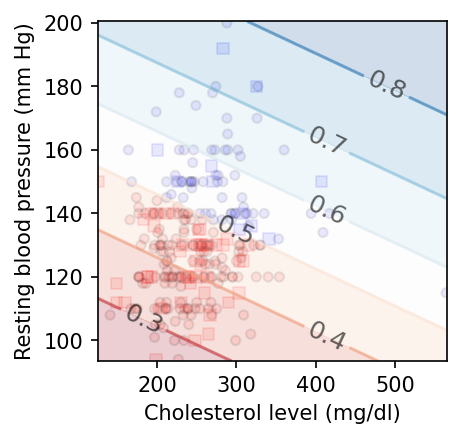

In [49]:
plt.figure()
ax = plt.gca()
ax.set_ylabel('Resting blood pressure (mm Hg)')
ax.set_xlabel('Cholesterol level (mg/dl)')
_ = points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, classifier, psize = 20, alpha = 0.1)

Notice that lines of equal probability, as might be expected are stright lines. What the classifier does is very intuitive: if the probability is greater than 0.5, it classifies the sample as type '1' (has heart disease), otherwise it classifies the sample to be class '0' (no heart disease). Thus in the diagram above, where we have plotted predicted values rather than actual labels of samples, there is a clear demarcation at the 0.5 probability line.

Again, this notion of trying to obtain the line or boundary of demarcation is what is called a **discriminative** classifier. The algorithm tries to find a decision boundary that separates those who have heart disease from those who do not. To classify a new sample, it checks on which side of the decision boundary the sample falls, and makes a prediction. In other words we are asking, given $\textbf{x}$, what is the probability of a given $y$, or, what is the likelihood $P(y|\textbf{x},\textbf{w})$?

### Discriminative vs Generative Classifiers

Logistic regression is what is known as a **discriminative classifier** as we learn a soft boundary between/among classes. Another paradigm is the **generative classifier** where we learn the distribution of each class. For more examples of generative classifiers, look [here](https://en.wikipedia.org/wiki/Generative_model). 